<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Forecasting-with-sktime" data-toc-modified-id="Forecasting-with-sktime-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Forecasting with sktime</a></span><ul class="toc-item"><li><span><a href="#Preliminaries" data-toc-modified-id="Preliminaries-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Preliminaries</a></span></li><li><span><a href="#Data" data-toc-modified-id="Data-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Data</a></span></li><li><span><a href="#Specifying-the-forecasting-task" data-toc-modified-id="Specifying-the-forecasting-task-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Specifying the forecasting task</a></span></li><li><span><a href="#Forecasting" data-toc-modified-id="Forecasting-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Forecasting</a></span><ul class="toc-item"><li><span><a href="#Naïve-baselines" data-toc-modified-id="Naïve-baselines-1.4.1"><span class="toc-item-num">1.4.1&nbsp;&nbsp;</span>Naïve baselines</a></span></li></ul></li><li><span><a href="#Theta-forecasting" data-toc-modified-id="Theta-forecasting-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Theta forecasting</a></span></li></ul></li><li><span><a href="#OLDER-SKTIME-VERSIONS" data-toc-modified-id="OLDER-SKTIME-VERSIONS-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>OLDER SKTIME VERSIONS</a></span><ul class="toc-item"><li><span><a href="#ReducedRegressionForecaster" data-toc-modified-id="ReducedRegressionForecaster-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span><code>ReducedRegressionForecaster</code></a></span></li><li><span><a href="#Manual-ReducedRegressonForecaster" data-toc-modified-id="Manual-ReducedRegressonForecaster-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Manual ReducedRegressonForecaster</a></span></li><li><span><a href="#Compositite-model-building" data-toc-modified-id="Compositite-model-building-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Compositite model building</a></span><ul class="toc-item"><li><span><a href="#Ensembling" data-toc-modified-id="Ensembling-2.3.1"><span class="toc-item-num">2.3.1&nbsp;&nbsp;</span>Ensembling</a></span></li></ul></li><li><span><a href="#Tuning" data-toc-modified-id="Tuning-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Tuning</a></span><ul class="toc-item"><li><span><a href="#Detrending" data-toc-modified-id="Detrending-2.4.1"><span class="toc-item-num">2.4.1&nbsp;&nbsp;</span>Detrending</a></span></li><li><span><a href="#Pipelining" data-toc-modified-id="Pipelining-2.4.2"><span class="toc-item-num">2.4.2&nbsp;&nbsp;</span>Pipelining</a></span></li></ul></li><li><span><a href="#Dynamic-forecasts" data-toc-modified-id="Dynamic-forecasts-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Dynamic forecasts</a></span></li><li><span><a href="#Prediction-intervals" data-toc-modified-id="Prediction-intervals-2.6"><span class="toc-item-num">2.6&nbsp;&nbsp;</span>Prediction intervals</a></span></li><li><span><a href="#Summary" data-toc-modified-id="Summary-2.7"><span class="toc-item-num">2.7&nbsp;&nbsp;</span>Summary</a></span></li><li><span><a href="#Useful-resources" data-toc-modified-id="Useful-resources-2.8"><span class="toc-item-num">2.8&nbsp;&nbsp;</span>Useful resources</a></span></li></ul></li></ul></div>

# Forecasting with sktime

In forecasting, we're interested in using past data to make temporal forward predictions. sktime provides common statistical forecasting algorithms and tools for building composite machine learning models.


<img src="img/forecasting.png" width=750 />

For more details, take a look at [our paper on forecasting with sktime](https://arxiv.org/abs/2005.08067) in which we discuss the forecasting API in more detail and use it to replicate and extend the M4 study.

## Preliminaries

In [3]:
import sktime
import warnings
warnings.filterwarnings('ignore')
sktime.__version__

'0.8.1'

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sktime.datasets import load_airline
from sktime.forecasting.model_selection import temporal_train_test_split
#from sktime.performance_metrics.forecasting import smape_loss
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError
from sktime.utils.plotting import plot_series
import sklearn
from sklearn import *
%matplotlib inline

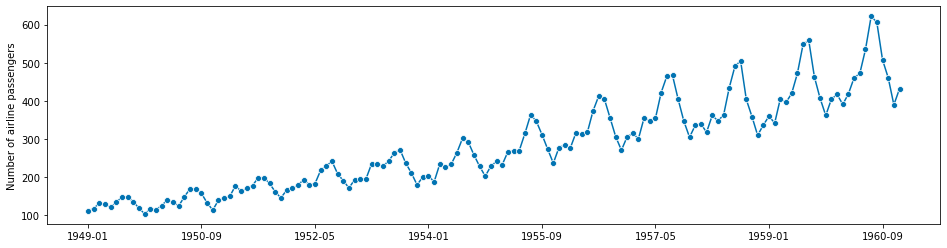

In [9]:
y = load_airline()
fig, ax = plot_series(y)

In [10]:
from sktime.forecasting import *

In [11]:
import statsmodels
import sktime
statsmodels.__version__, sktime.__version__

('0.12.1', '0.8.1')

## Data
For this tutorial, we will use the famous Box-Jenkins airline data set, which shows the number of international airline
passengers per month from 1949-1960.

As well as using the original time series (which is a classic example of a *multiplicative* time series), we will create an *additive* time series by performing a log-transform on the original data, so we may compare forecasters against both types of model.

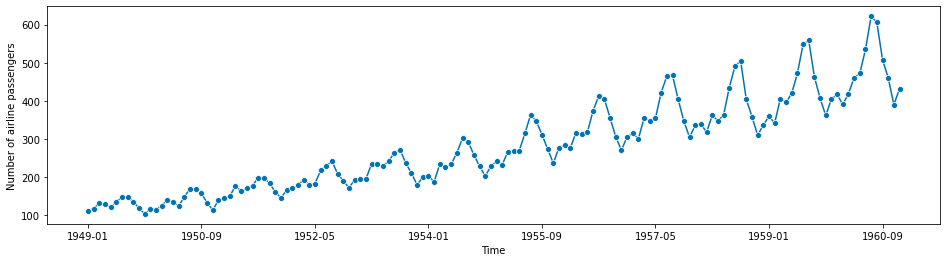

In [12]:
y = load_airline()
fig, ax = plot_series(y)
ax.set(xlabel="Time", ylabel="Number of airline passengers");

## Specifying the forecasting task

Next we will define a forecasting task.

* We will try to predict the last 3 years of data, using the previous years as training data. Each point in the series represents a month, so we should hold out the last 36 points as test data, and use 36-step ahead forecasting horizon to evaluate forecasting performance.
* We will use the sMAPE (symmetric mean absolute percentage error) to quantify the accuracy of our forecasts. A lower sMAPE means higher accuracy.

We can split the data as follows:

108 36


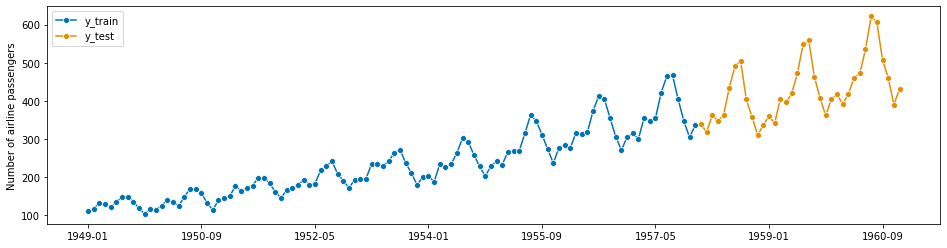

In [13]:
y_train, y_test = temporal_train_test_split(y, test_size=36)
plot_series(y_train, y_test, labels=["y_train", "y_test"])
print(y_train.shape[0], y_test.shape[0])

When we want to generate forecasts, we need to specify **the forecasting horizon and pass that to our forecasting algorithm**. We can specify the forecasting horizon as a simple numpy array of the steps ahead, relative to the end of the training series:

In [14]:
fh = np.arange(len(y_test)) + 1
fh

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36])

So here we're interested in predicting from the first to to the 36th step ahead.

Of course you could you use other forecasting horizons. For example, to predict only the second and fifth step ahead, you could write:

```python
fh = np.array([2, 5])  # 2nd and 5th step ahead
```

## Forecasting

Like in scikit-learn, in order to make forecasts, we need to first specify (or build) a model, then fit it to the training data, and finally call predict to generate forecasts for the given forecasting horizon.

sktime comes with several forecasting algorithms (or forecasters) and tools for composite model building. All forecaster share a common interface. Forecasters are trained on a single series of data and make forecasts for the provided forecasting horizon.

### Naïve baselines
Let's start with two naïve forecasting strategies which can serve as references for comparison of more sophisticated approaches.

1. We always predict the last value observed (in the training series),
2. We predict the last value observed in the same season.

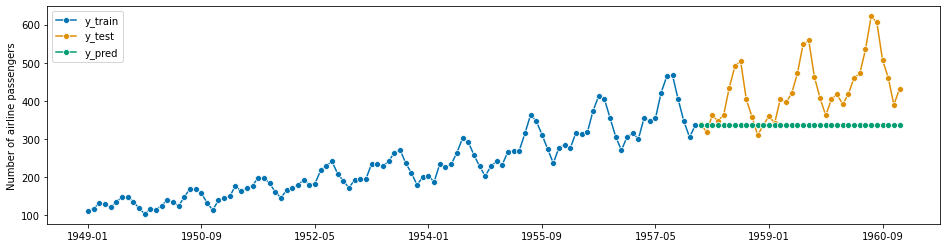

In [15]:
# we can do that with a few lines of code
y_pred = np.repeat(y_train.iloc[-1], len(fh))
y_pred = pd.Series(y_pred, index=y_train.index[-1] + fh)

plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);

In [16]:
# using sktime 
from sktime.forecasting.naive import NaiveForecaster
forecaster = NaiveForecaster(strategy="last")
forecaster.fit(y_train)
y_last = forecaster.predict(fh)
type(fh), type(y_last)

(numpy.ndarray, pandas.core.series.Series)

Note that:
    
- the input of `forecaster.predict(fh)` is a `np.ndarray`

- the output of `forecaster.predict(fh)` is a `pandas.Series`


How can the forecaster predict anything if we are simply passing a numpy array of indices?

The key idea is that the forecasting method stores the series which was used for training in `._y`

In [17]:
forecaster._y

1949-01    112.0
1949-02    118.0
1949-03    132.0
1949-04    129.0
1949-05    121.0
           ...  
1957-08    467.0
1957-09    404.0
1957-10    347.0
1957-11    305.0
1957-12    336.0
Freq: M, Name: Number of airline passengers, Length: 108, dtype: float64

0.23195770387951434

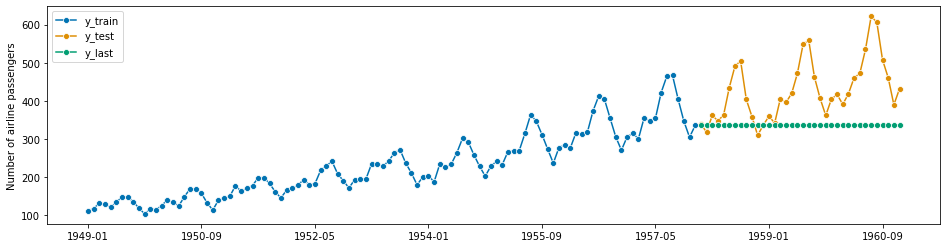

In [18]:
plot_series(y_train, y_test, y_last, labels=["y_train", "y_test", "y_last"]);
#smape_loss(y_last, y_test)
mape = MeanAbsolutePercentageError()
mape(y_last, y_test)

0.145427686270316

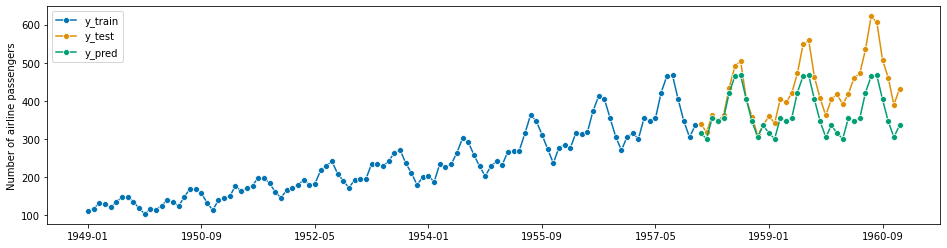

In [19]:
forecaster = NaiveForecaster(strategy="last", sp=12)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mape(y_pred, y_test)

In [20]:
fh

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36])

we can predict a slice of any user defined length taking as input in the model the 

```python
forecast_indices = np.array(range(10))
```


array([1, 2, 3, 4, 5, 6, 7, 8, 9])

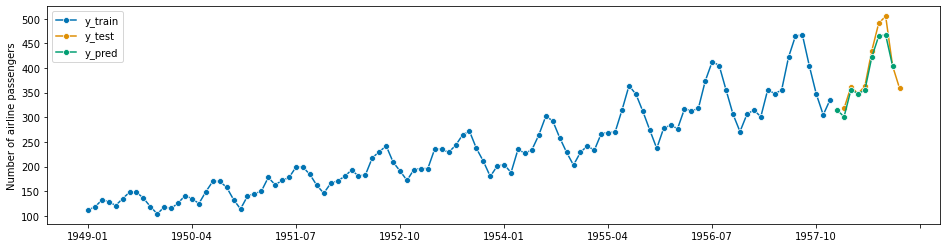

In [21]:
forecaster = NaiveForecaster(strategy="last", sp=12)

forecast_indices_10 = np.array(range(1,10))

y_pred = forecaster.predict(forecast_indices_10)
plot_series(y_train,y_test.iloc[forecast_indices_10], y_pred, labels=["y_train", "y_test", "y_pred"])
forecast_indices_10
#smape_loss(y_test, y_pred[forecast_indices_10])

In [22]:
forecaster.__dict__

{'strategy': 'last',
 'sp': 12,
 'window_length': None,
 '_is_fitted': True,
 '_y': 1949-01    112.0
 1949-02    118.0
 1949-03    132.0
 1949-04    129.0
 1949-05    121.0
            ...  
 1957-08    467.0
 1957-09    404.0
 1957-10    347.0
 1957-11    305.0
 1957-12    336.0
 Freq: M, Name: Number of airline passengers, Length: 108, dtype: float64,
 '_X': None,
 '_fh': ForecastingHorizon([1, 2, 3, 4, 5, 6, 7, 8, 9], dtype='int64', is_relative=True),
 '_cutoff': Period('1957-12', 'M'),
 '_converter_store_y': {},
 '_tags_dynamic': {},
 '_y_mtype_last_seen': 'pd.Series',
 '_forecaster': ColumnEnsembleForecaster(forecasters=_NaiveForecaster(sp=12))}

## Theta forecasting

In [26]:
from sktime.forecasting import *
from sktime.forecasting.theta import ThetaForecaster

array([1, 2, 3, 4, 5, 6, 7, 8, 9])

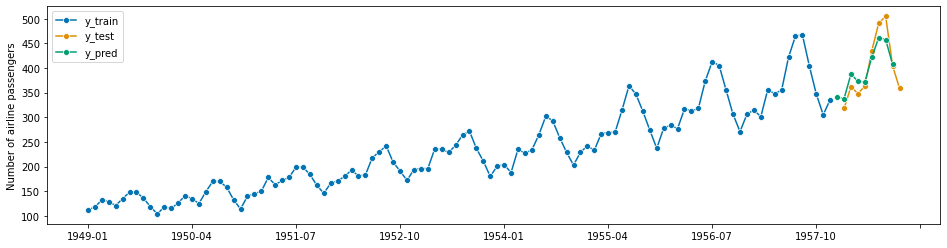

In [27]:
forecaster = ThetaForecaster(sp=12)
forecaster.fit(y_train)

forecast_indices_10 = np.array(range(1,10))

y_pred = forecaster.predict(forecast_indices_10)
plot_series(y_train,y_test.iloc[forecast_indices_10], y_pred, labels=["y_train", "y_test", "y_pred"])
forecast_indices_10

sp:
    
The number of observations that constitute a seasonal period for a
multiplicative deseasonaliser, which is used if seasonality is
detected in the
training data. 

In [68]:
forecaster.deseasonalizer_

Deseasonalizer(model='multiplicative', sp=12)

In [69]:
#help(forecaster.deseasonalizer_)

The deasosanalizer at fit time does the following:
    
```python
        def fit(self, Z, X=None):
        """Fit to data.
        Parameters
        ----------
        Z : pd.Series
        X : pd.DataFrame
        Returns
        -------
        self : an instance of self
        """
        z = check_series(Z, enforce_univariate=True)
        self._set_y_index(z)
        sp = check_sp(self.sp)

        # apply seasonal decomposition
        self.seasonal_ = seasonal_decompose(
            z,
            model=self.model,
            period=sp,
            filt=None,
            two_sided=True,
            extrapolate_trend=0,
        ).seasonal.iloc[:sp]

        self._is_fitted = True
```

# OLDER SKTIME VERSIONS


## `ReducedRegressionForecaster`

We can use any regressor from sklearn with `ReducedRegressionForecaster` to do forecasting

`ReducedRegressionForecaster` is:

    Forecasting based on reduction to tabular regression.

    When fitting, a rolling window approach is used to first transform the target series into panel data which is then used to train a regressor. During prediction, the last available data is used as input to the fitted regressors to make forecasts.

In [86]:
import sktime
from sktime import regression
from sktime.forecasting.compose._reduce import ReducedRegressionForecaster

In [87]:
?ReducedRegressionForecaster

0.14008272913734346

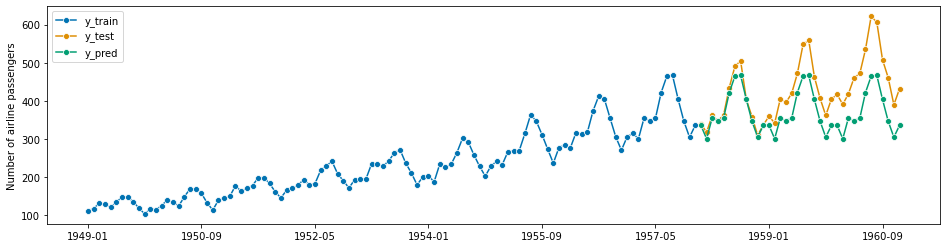

In [90]:
from sklearn.neighbors import KNeighborsRegressor

regressor = KNeighborsRegressor(n_neighbors=1)
forecaster = ReducedRegressionForecaster(estimator=regressor,
                                         scitype="tabular-regressor", 
                                         window_length=20, 
                                         strategy="recursive")
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);
mape(y_test, y_pred)

0.11298125176781294

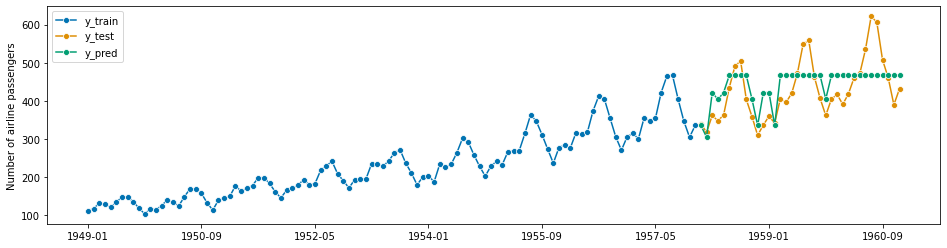

In [92]:
from sklearn.tree import DecisionTreeRegressor

regressor = DecisionTreeRegressor()
forecaster = ReducedRegressionForecaster(estimator=regressor,
                                         scitype="tabular-regressor", 
                                         window_length=50, 
                                         strategy="recursive")

forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);
mape(y_test, y_pred)

0.083048119711773

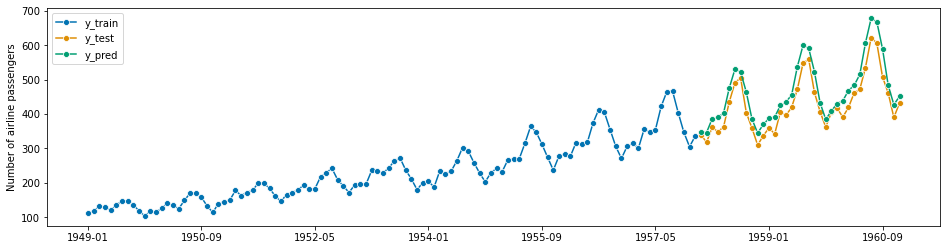

In [94]:
from sklearn import *
from sklearn.neural_network import MLPRegressor

regressor = MLPRegressor(random_state=1234, max_iter=300, hidden_layer_sizes=[500])
forecaster = ReducedRegressionForecaster(estimator=regressor,
                                         scitype="tabular-regressor", 
                                         window_length=20, 
                                         strategy="recursive")
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);
mape(y_test, y_pred)

0.7566616655604718

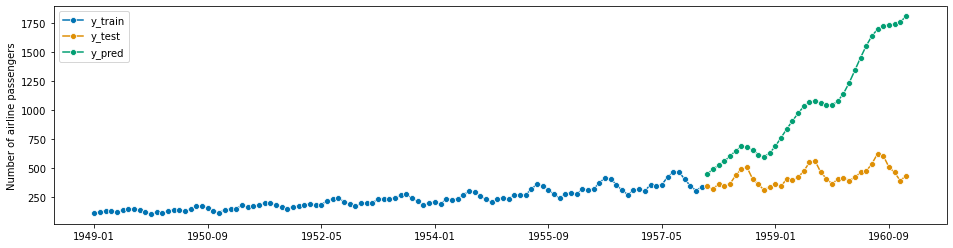

In [95]:
from sklearn import *
from sklearn.neural_network import MLPRegressor

regressor = MLPRegressor(random_state=1234, max_iter=600,
                         hidden_layer_sizes=[500],
                         learning_rate_init=0.000001, solver='sgd')

forecaster = ReducedRegressionForecaster(estimator=regressor,
                                         scitype="tabular-regressor", 
                                         window_length=20, 
                                         strategy="recursive")

forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);
mape(y_test, y_pred)

###### Example showing problems

Why is autotunning important:
    
-    Many methods in timeseries are very (VERY) sensible to changing conditions

The following example shows the exact same model than the previous cell with a diferend seed in the timeseries


Note that this means that during the tunning process, models should be trained more than once (if this happens)

- Change of having a good model



0.7566616655604718

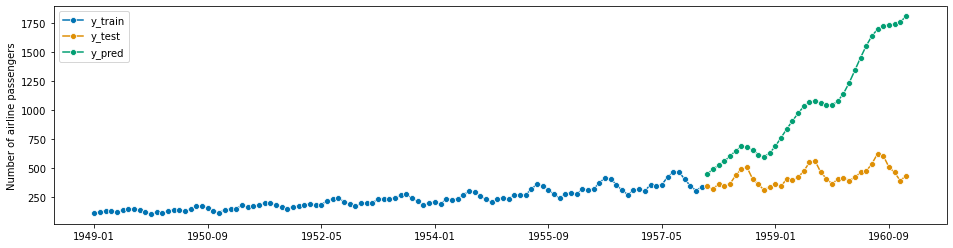

In [98]:
from sklearn import *
from sklearn.neural_network import MLPRegressor

regressor = MLPRegressor(random_state=1234, max_iter=600,
                         hidden_layer_sizes=[500],
                         learning_rate_init=0.000001, solver='sgd')

forecaster = ReducedRegressionForecaster(estimator=regressor,
                                         scitype="tabular-regressor", 
                                         window_length=20, 
                                         strategy="recursive")

forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);
mape(y_test, y_pred)

1.8909347704345234

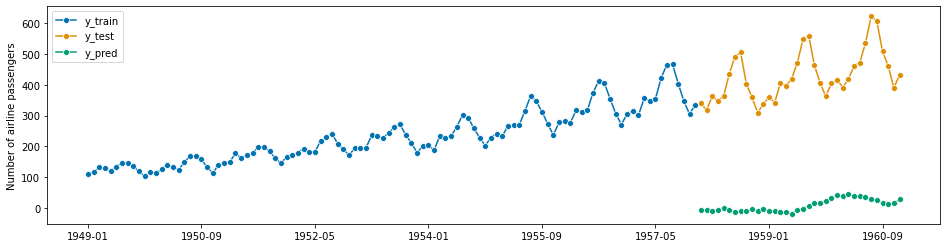

In [102]:
from sklearn import *
from sklearn.neural_network import MLPRegressor

regressor = MLPRegressor(random_state=12,
                         max_iter=500,
                         hidden_layer_sizes=[500],
                         learning_rate_init=0.00001,
                         solver='sgd')

forecaster = ReducedRegressionForecaster(estimator=regressor,
                                         scitype="tabular-regressor", 
                                         window_length=50, 
                                         strategy="recursive")
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);

mape(y_test, y_pred)

## Manual ReducedRegressonForecaster

In [103]:
forecaster.__dict__

{'_is_fitted': True,
 '_y': 1949-01    112.0
 1949-02    118.0
 1949-03    132.0
 1949-04    129.0
 1949-05    121.0
            ...  
 1957-08    467.0
 1957-09    404.0
 1957-10    347.0
 1957-11    305.0
 1957-12    336.0
 Freq: M, Name: Number of airline passengers, Length: 108, dtype: float64,
 '_X': None,
 '_fh': ForecastingHorizon([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
             18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
             35, 36],
            dtype='int64', is_relative=True),
 '_cutoff': Period('1957-12', 'M'),
 '_converter_store_y': {},
 '_tags_dynamic': {},
 'window_length': 50,
 'window_length_': 50,
 'estimator': MLPRegressor(hidden_layer_sizes=[500], learning_rate_init=1e-05, max_iter=500,
              random_state=12, solver='sgd'),
 '_cv': None,
 '_y_mtype_last_seen': 'pd.Series',
 'estimator_': MLPRegressor(hidden_layer_sizes=[500], learning_rate_init=1e-05, max_iter=500,
              random_state=12

In [106]:
window = forecaster._get_last_window()[0]
window

array([180., 201., 204., 188., 235., 227., 234., 264., 302., 293., 259.,
       229., 203., 229., 242., 233., 267., 269., 270., 315., 364., 347.,
       312., 274., 237., 278., 284., 277., 317., 313., 318., 374., 413.,
       405., 355., 306., 271., 306., 315., 301., 356., 348., 355., 422.,
       465., 467., 404., 347., 305., 336.])

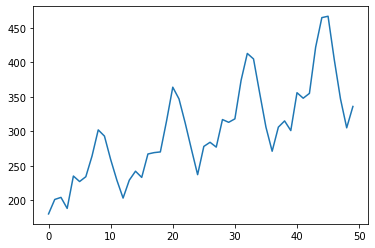

In [107]:
plt.plot(window)

Note that the first prediction on the test data is done taking as input the window and predingting a single value.

That is:

In [113]:
forecast_1 = forecaster.estimator_.predict(np.array([window]))
forecast_1

array([-5.08798857])

This value is precisely what we find in `y_pred.iloc[0]`

In [114]:
y_pred.iloc[0]

-5.087988565077073

How do we find the following next forecasting value? that is, what we have in `y_pred.iloc[1]` ?

We just need to move the sliding window adding the newly generated prediction found in `forecast_1`
and then using the regressor again to generate the next value.

In [117]:
next_window = np.roll(window,-1)
next_window[-1] = forecast_1
forecast_2 = forecaster.estimator_.predict(np.array([next_window]))
forecast_2

array([-6.64436316])

which is precisely

In [118]:
y_pred.iloc[1]

-6.644363162711766

Note that we can repeat this process many times to generate the recursive forecast that ReducedRegressionForecaster(strategy="recursive") uses

In [119]:
n_forecast_steps = len(y_pred)

In [120]:
np.array(y[-10:])

array([419., 461., 472., 535., 622., 606., 508., 461., 390., 432.])

In [125]:
def reducedregresorforecasting(forecaster, n_steps):
    predictions = []
    window = forecaster._get_last_window()[0]
    prediction = forecaster.estimator_.predict([window])
    predictions.append(prediction)
    for i in range(n_steps):
        window = np.roll(window,-1)
        window[-1] = prediction
        prediction =  forecaster.estimator_.predict([window])
        predictions.append(prediction)
    return np.array(predictions).flatten()


In [126]:
y_pred_custom = reducedregresorforecasting(forecaster,len(fh)-1)

In [127]:
y_pred = forecaster.predict(fh)

In [128]:
y_pred_custom

array([ -5.08798857,  -6.64436316,  -7.62069318,  -6.3279947 ,
         1.52135006,  -4.16620518, -11.13378037,  -9.58168661,
        -9.42775092,  -2.51343677,  -9.86438298,  -2.92872534,
        -8.43011147,  -9.15442595, -12.75532258, -12.61903212,
       -18.45532707,  -4.61450639,  -1.09912082,   8.00811215,
        15.34399469,  16.63326283,  24.77441729,  31.62236523,
        42.87290357,  38.7313807 ,  46.95349896,  39.35044428,
        41.05794349,  35.08707768,  30.06365436,  26.10403493,
        18.18645871,  13.72526368,  15.5012662 ,  28.56498346])

In [129]:
y_pred.values

array([ -5.08798857,  -6.64436316,  -7.62069318,  -6.3279947 ,
         1.52135006,  -4.16620518, -11.13378037,  -9.58168661,
        -9.42775092,  -2.51343677,  -9.86438298,  -2.92872534,
        -8.43011147,  -9.15442595, -12.75532258, -12.61903212,
       -18.45532707,  -4.61450639,  -1.09912082,   8.00811215,
        15.34399469,  16.63326283,  24.77441729,  31.62236523,
        42.87290357,  38.7313807 ,  46.95349896,  39.35044428,
        41.05794349,  35.08707768,  30.06365436,  26.10403493,
        18.18645871,  13.72526368,  15.5012662 ,  28.56498346])

## Compositite model building

sktime provides a modular API for composite model building for forecasting.

### Ensembling
Like scikit-learn, sktime provides a meta-forecaster to ensemble multiple forecasting algorithms. For example, we can combine different variants of exponential smoothing as follows:

In [130]:
from sktime.forecasting import *

In [134]:
from sktime.forecasting import exp_smoothing

In [135]:
?ExponentialSmoothing

0.07854053582629221

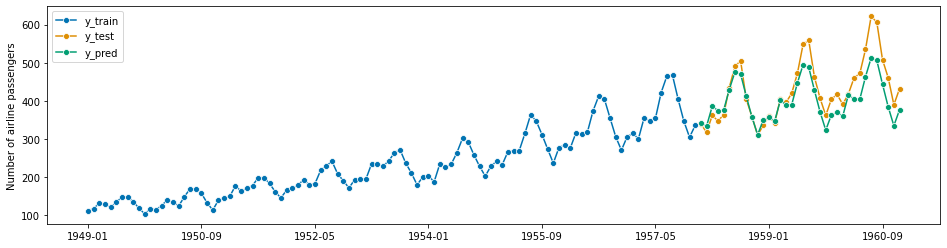

In [136]:
from sktime.forecasting.compose import EnsembleForecaster
from sktime.forecasting.exp_smoothing import ExponentialSmoothing

forecaster = EnsembleForecaster([
    ("ses", ExponentialSmoothing(seasonal="multiplicative", sp=12)),
    ("holt", ExponentialSmoothing(trend="add", damped_trend=False, seasonal="multiplicative", sp=12)),
    ("damped", ExponentialSmoothing(trend="add", damped_trend=True, seasonal="multiplicative", sp=12))
])
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);
mape(y_test, y_pred)

## Tuning
In the `ReducedRegressionForecaster`, both the `window_length` and `strategy` arguments are hyper-parameters which we may want to optimise.

In [146]:
from sktime.forecasting.model_selection import ForecastingGridSearchCV,SlidingWindowSplitter

forecaster = ReducedRegressionForecaster(estimator=regressor,
                                         scitype="tabular-regressor", 
                                         window_length=15, 
                                         strategy="recursive")

param_grid = {"window_length": [5, 10, 15]}

# we fit the forecaster on the initial window, and then use temporal cross-validation to find the optimal parameter
cv = SlidingWindowSplitter(initial_window=int(len(y_train) * 0.5))
gscv = ForecastingGridSearchCV(forecaster, cv=cv, param_grid=param_grid)
gscv.fit(y_train)

#fh = np.arange(len(y_test)) + 1
y_pred = gscv.predict(fh)

ValueError: The `window_length` and `fh` are incompatible with the length of `y`

In [56]:
gscv

ForecastingGridSearchCV(cv=<sktime.forecasting.model_selection._split.SlidingWindowSplitter object at 0x1254f70d0>,
                        forecaster=RecursiveRegressionForecaster(regressor=MLPRegressor(hidden_layer_sizes=[500],
                                                                                        learning_rate_init=1e-05,
                                                                                        max_iter=500,
                                                                                        random_state=12,
                                                                                        solver='sgd'),
                                                                 window_length=15),
                        param_grid={'window_length': [5, 10, 15]})

1.9857018696760105

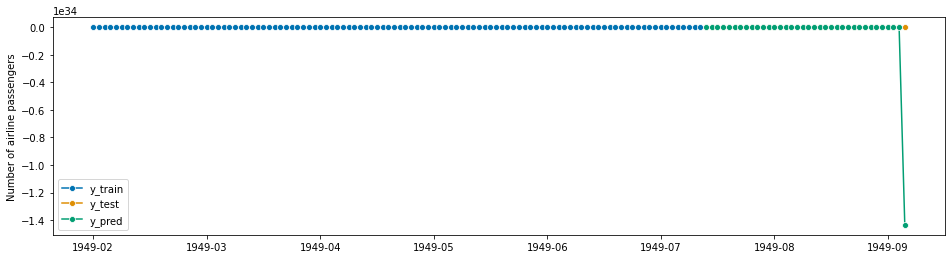

In [57]:
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);
smape_loss(y_test, y_pred)

In [58]:
gscv.best_params_

{'window_length': 10}

Using scikit-learn's `GridSearchCV`, we can tune regressors imported from scikit-learn, in addition to tuning `window_length`.

In [59]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sktime.forecasting.compose import RecursiveRegressionForecaster

# tuning the 'n_estimator' hyperparameter of RandomForestRegressor from scikit-learn
regressor_param_grid = {"n_estimators": [100, 200, 300]}
forecaster_param_grid = {"window_length": [5,10,15,20,25]}

# create a tunnable regressor with GridSearchCV
regressor = GridSearchCV(RandomForestRegressor(), param_grid=regressor_param_grid)
forecaster = RecursiveRegressionForecaster(regressor, window_length=15)

cv = SlidingWindowSplitter(initial_window=int(len(y_train) * 0.5))
gscv = ForecastingGridSearchCV(forecaster, cv=cv, param_grid=forecaster_param_grid)

0.1258518821762985

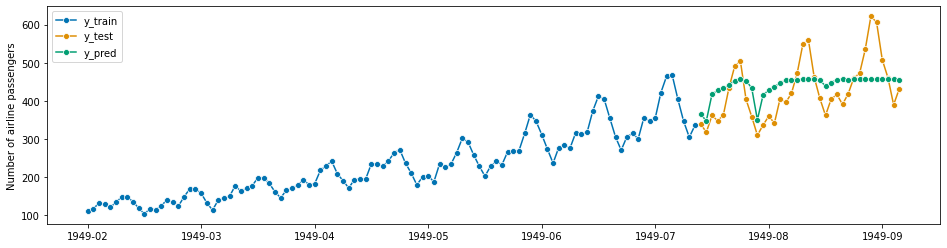

In [60]:
gscv.fit(y_train)
y_pred = gscv.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);
smape_loss(y_test, y_pred)

In [61]:
print(gscv.best_params_, gscv.best_forecaster_.regressor_.best_params_)

{'window_length': 25} {'n_estimators': 100}


To access performance on a particular metric during tuning, we can use the `scoring` argument of `ForecastingGridSearchCV`.

In [62]:
from sktime.performance_metrics.forecasting import sMAPE

gscv = ForecastingGridSearchCV(forecaster, cv=cv, param_grid=forecaster_param_grid, scoring=sMAPE())
gscv.fit(y_train)
print(gscv.cv_results_)

{'mean_fit_time': array([3.44583082, 3.23094606, 3.30962801, 3.27113914, 3.35790586]), 'mean_score_time': array([1.256428  , 0.54759097, 0.54650712, 0.50168395, 0.8589251 ]), 'param_window_length': masked_array(data=[5, 10, 15, 20, 25],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'window_length': 5}, {'window_length': 10}, {'window_length': 15}, {'window_length': 20}, {'window_length': 25}], 'mean_test_sMAPE': array([0.29941392, 0.27138692, 0.2474421 , 0.249066  , 0.24201947]), 'rank_test_sMAPE': array([5, 4, 2, 3, 1], dtype=int32)}


### Detrending
Note that so far the reduction approach above does not take any seasonal or trend into account, but we can easily specify a pipeline which first detrends the data.

sktime provides a generic detrender, a transformer which uses any forecaster and returns the in-sample residuals of the forecaster's predicted values. For example, to remove the linear trend of a time series, we can write:

In [82]:
transformer.get_params()

{'forecaster__degree': 1,
 'forecaster__regressor': None,
 'forecaster__with_intercept': True,
 'forecaster': PolynomialTrendForecaster()}

In [114]:
forecaster = PolynomialTrendForecaster(degree=1)
fh_ins = -np.arange(len(y_train)) # in-sample forecasting horizon
y_pred = forecaster.fit(y_train).predict(fh=fh_ins)
y_pred[-1]/y_pred[0]

def check_treding(y_pred, threshold):
    m = y_pred[-1]/y_pred[0] 
    if m > 0 + threshold:
        return 1
    elif m < 0 - threshold:
        return -1
    else:
        return 0
    
check_treding(y_pred,0.001)

### 1h 1day 1week

1

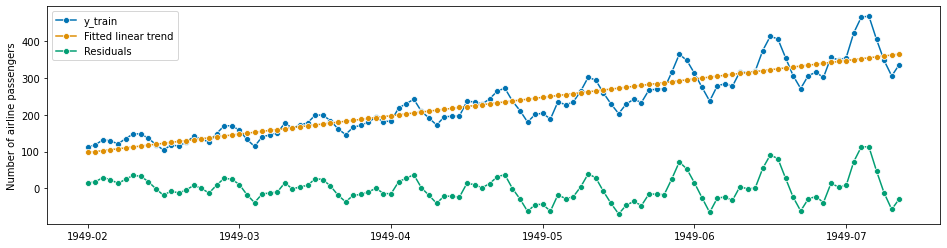

In [91]:
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.transformers.single_series.detrend import Detrender

# liner detrending
forecaster = PolynomialTrendForecaster(degree=1)
transformer = Detrender(forecaster=forecaster)
yt = transformer.fit_transform(y_train)

# internally, the Detrender uses the in-sample predictions of the PolynomialTrendForecaster
forecaster = PolynomialTrendForecaster(degree=1)
fh_ins = -np.arange(len(y_train)) # in-sample forecasting horizon
y_pred = forecaster.fit(y_train).predict(fh=fh_ins)

plot_series(y_train, y_pred, yt, labels=["y_train", "Fitted linear trend", "Residuals"]);

In [37]:
#plt.plot(y_pred)

### Pipelining

Let's use the detrender in a pipeline together with de-seasonalisation. Note that in forecasting, when we apply data transformations before fitting, we need to apply the inverse transformation to the predicted values. For this purpose, we provide the following pipeline class:

0.052757463516906765

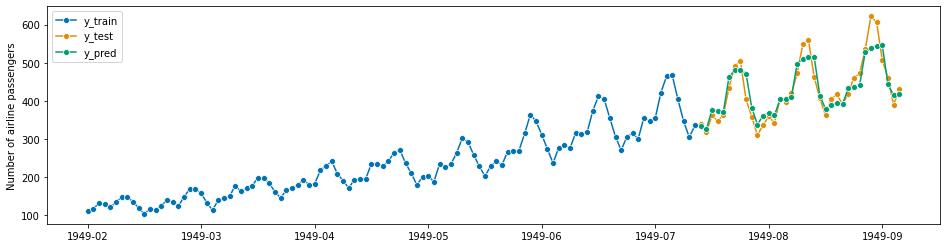

In [120]:
from sktime.forecasting.compose import TransformedTargetForecaster
from sktime.transformers.single_series.detrend import Deseasonalizer

forecaster = TransformedTargetForecaster([
    #("deseasonalise", Deseasonalizer(model="multiplicative", sp=2)),
    ("detrend", Detrender(forecaster=PolynomialTrendForecaster(degree=1))),
    ("forecast", ReducedRegressionForecaster(regressor=regressor, window_length=15, strategy="recursive"))
])

forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);
smape_loss(y_test, y_pred)

Of course, we could try again to optimise the hyper-parameters of components of the pipeline.

Below we discuss two other aspects of forecasting: online learning, where we want to dynamically update forecasts as new data comes in, and prediction intervals, which allow us to quantify the uncertainty of our forecasts.

## Dynamic forecasts

For model evaluation, we sometimes want to evaluate multiple forecasts, using temporal cross-validation with a sliding window over the test data. For this purpose, all forecasters in sktime have a `update_predict` method. Here we make repeated single-step ahead forecasts over the test set.

Note that the forecasting task is changed: while we still make 36 predictions, we do not predict 36 steps ahead, but instead make 36 single-step-ahead predictions.

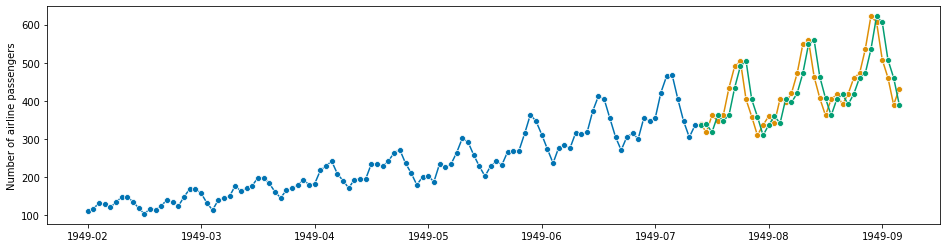

In [65]:
forecaster = NaiveForecaster(strategy="last")
forecaster.fit(y_train)
cv = SlidingWindowSplitter(fh=1)
y_pred = forecaster.update_predict(y_test, cv)
smape_loss(y_test, y_pred)
plot_series(y_train, y_test, y_pred);

For a single update, you can use the `update` method.

## Prediction intervals
So far, we've only looked at point forecasts. In many cases, we're also interested in prediction intervals. sktime's interface support prediction intervals, but we haven't implemented them for all algorithms yet.

Here, we use the Theta forecasting algorithm:

In [66]:
?ax.fill_between

In [67]:
from sktime.forecasting.theta import ThetaForecaster
forecaster = ThetaForecaster(sp=12)
forecaster.fit(y_train)
alpha = 0.05  # 95% prediction intervals
y_pred, pred_ints = forecaster.predict(fh, return_pred_int=True, alpha=alpha)
smape_loss(y_test, y_pred)

#fig, ax = plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
#ax.fill_between(y_pred.index, pred_ints["lower"], pred_ints["upper"], 
#                alpha=0.2, color="green", label=f"{1 - alpha}% prediction intervals")
#plt.legend();

0.08661468139978168

## Summary

As we have seen, in order to make forecasts, we need to first specify (or build) a model, then fit it to the training data, and finally call predict to generate forecasts for the given forecasting horizon. 

* sktime comes with several forecasting algorithms (or forecasters) and tools for composite model building. All forecaster share a common interface. Forecasters are trained on a single series of data and make forecasts for the provided forecasting horizon.

* sktime has a number of statistical forecasting algorithms, based on implementations in statsmodels. For example, to use exponential smoothing with an additive trend component and multiplicative seasonality, we can write the following.


## Useful resources
* For more details, take a look at [our paper on forecasting with sktime](https://arxiv.org/abs/2005.08067) in which we discuss the forecasting API in more detail and use it to replicate and extend the M4 study.
* For a good introduction to forecasting, see [Hyndman, Rob J., and George Athanasopoulos. Forecasting: principles and practice. OTexts, 2018](https://otexts.com/fpp2/).
* For comparative benchmarking studies/forecasting competitions, see the [M4 competition](https://www.sciencedirect.com/science/article/pii/S0169207019301128) and the currently running [M5 competition](https://www.kaggle.com/c/m5-forecasting-accuracy/overview).